## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

### A note on variation of output

Note as always that due to the use of random numbers, some of the results here may differ from those in the book (since I re-ran everything to prepare this notebook), and will probably be different yet again if you run this notebook.

## Chapter 18: Autoencoders - Notebook 2: MNIST 1

In [7]:
# Some code inspired or based on:
#    https://blog.keras.io/building-autoencoders-in-keras.html
#    https://jmetzen.github.io/2015-11-27/vae.html
#    https://arxiv.org/pdf/1606.05908.pdf  (https://github.com/cdoersch/vae_tutorial)
#

In [8]:
from keras.api.datasets import mnist
from keras.api.models import Sequential, Model
from keras.api.layers import Dense
import numpy as np
import h5py
from pathlib import Path
import matplotlib.pyplot as plt

from keras._tf_keras.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

In [9]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [10]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [11]:
random_seed = 42
np.random.seed(random_seed)

# Read MNIST data. We won't be using the y_train or y_test data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
pixels_per_image = np.prod(X_train.shape[1:])

# Cast values into the current floating-point type
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# Normalize the range from [0,255] to [0,1]
X_train /= 255.
X_test /= 255.

# Reshape the data into a grid with one row per sample, each row 784 (28*28) pixels
X_train = X_train.reshape((len(X_train), pixels_per_image))
X_test = X_test.reshape((len(X_test), pixels_per_image))

print("X_train.shape = ",X_train.shape, " X_test.shape = ",X_test.shape)

X_train.shape =  (60000, 784)  X_test.shape =  (10000, 784)


In [12]:
# Show a grid of MNIST images and our prediction for each one

def draw_predictions_set(predictions, filename=None):
    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplot(2, 5, i+6)
        plt.imshow(predictions[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure(filename+'-predictions')
    plt.show()

In [13]:
# Build and train our first autoencoder
num_latent_vars = 20

AE1 = Sequential()
AE1.add(Dense(num_latent_vars, input_dim=pixels_per_image, activation='relu'))
AE1.add(Dense(pixels_per_image, activation='sigmoid'))
AE1.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "NB2-AE1-weights"
np.random.seed(42)
if not file_helper.load_model_weights(AE1, weights_filename):
    AE1.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(AE1, weights_filename)

D:\CourseDML\git\course-ml\fmi-2025-03-ann-cnn\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
469/469 - 3s - 6ms/step - loss: 0.6937 - val_loss: 0.6936
Epoch 2/50
469/469 - 1s - 3ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 3/50
469/469 - 1s - 3ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
469/469 - 1s - 3ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 5/50
469/469 - 1s - 2ms/step - loss: 0.6927 - val_loss: 0.6926
Epoch 6/50
469/469 - 1s - 3ms/step - loss: 0.6925 - val_loss: 0.6924
Epoch 7/50
469/469 - 1s - 3ms/step - loss: 0.6922 - val_loss: 0.6921
Epoch 8/50
469/469 - 1s - 3ms/step - loss: 0.6920 - val_loss: 0.6919
Epoch 9/50
469/469 - 1s - 3ms/step - loss: 0.6918 - val_loss: 0.6917
Epoch 10/50
469/469 - 1s - 3ms/step - loss: 0.6915 - val_loss: 0.6914
Epoch 11/50
469/469 - 1s - 3ms/step - loss: 0.6913 - val_loss: 0.6912
Epoch 12/50
469/469 - 1s - 3ms/step - loss: 0.6910 - val_loss: 0.6909
Epoch 13/50
469/469 - 2s - 3ms/step - loss: 0.6908 - val_loss: 0.6907
Epoch 14/50
469/469 - 1s - 3ms/step - loss: 0.6905 - val_loss: 0.6904
Epoch 15/50
469/469 - 1s - 3m

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step


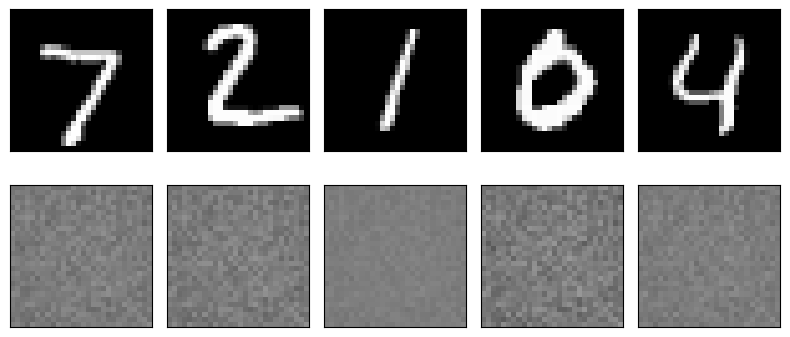

In [14]:
predictions1 = AE1.predict(X_test)
draw_predictions_set(predictions1, 'NB2-MLP-AE1')

In [15]:
# Build and train our second, more compress-y autoencoder
num_latent_vars = 10

AE2 = Sequential()
AE2.add(Dense(num_latent_vars, input_dim=pixels_per_image, activation='relu'))
AE2.add(Dense(pixels_per_image, activation='sigmoid'))
AE2.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "NB2-AE2-weights"
np.random.seed(42)
if not file_helper.load_model_weights(AE2, weights_filename):
    AE2.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(AE2, weights_filename)

Epoch 1/50
469/469 - 2s - 4ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 2/50
469/469 - 1s - 2ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 3/50
469/469 - 1s - 3ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 4/50
469/469 - 1s - 3ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 5/50
469/469 - 1s - 3ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 6/50
469/469 - 1s - 2ms/step - loss: 0.6924 - val_loss: 0.6923
Epoch 7/50
469/469 - 1s - 2ms/step - loss: 0.6922 - val_loss: 0.6922
Epoch 8/50
469/469 - 1s - 2ms/step - loss: 0.6921 - val_loss: 0.6920
Epoch 9/50
469/469 - 1s - 3ms/step - loss: 0.6919 - val_loss: 0.6918
Epoch 10/50
469/469 - 1s - 3ms/step - loss: 0.6917 - val_loss: 0.6916
Epoch 11/50
469/469 - 1s - 3ms/step - loss: 0.6915 - val_loss: 0.6914
Epoch 12/50
469/469 - 1s - 3ms/step - loss: 0.6913 - val_loss: 0.6912
Epoch 13/50
469/469 - 1s - 3ms/step - loss: 0.6911 - val_loss: 0.6910
Epoch 14/50
469/469 - 1s - 3ms/step - loss: 0.6910 - val_loss: 0.6909
Epoch 15/50
469/469 - 1s - 3m

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


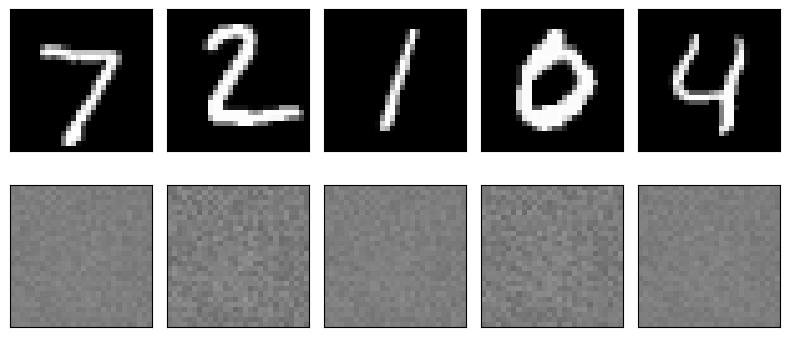

In [16]:
predictions2 = AE2.predict(X_test)
draw_predictions_set(predictions2, 'NB2-MLP-AE2')

In [17]:
# Build and train our third, super compress-y autoencoder
num_latent_vars = 3

AE3 = Sequential()
AE3.add(Dense(num_latent_vars, input_dim=pixels_per_image, activation='relu'))
AE3.add(Dense(pixels_per_image, activation='sigmoid'))
AE3.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "NB2-AE3-weights"
np.random.seed(42)
if not file_helper.load_model_weights(AE3, weights_filename):
    AE3.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(AE3, weights_filename)

Epoch 1/50
469/469 - 2s - 4ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 2/50
469/469 - 1s - 2ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 3/50
469/469 - 1s - 2ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 4/50
469/469 - 1s - 3ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 5/50
469/469 - 1s - 3ms/step - loss: 0.6926 - val_loss: 0.6926
Epoch 6/50
469/469 - 1s - 3ms/step - loss: 0.6925 - val_loss: 0.6924
Epoch 7/50
469/469 - 1s - 3ms/step - loss: 0.6924 - val_loss: 0.6923
Epoch 8/50
469/469 - 1s - 2ms/step - loss: 0.6923 - val_loss: 0.6922
Epoch 9/50
469/469 - 1s - 2ms/step - loss: 0.6922 - val_loss: 0.6921
Epoch 10/50
469/469 - 1s - 2ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 11/50
469/469 - 1s - 2ms/step - loss: 0.6919 - val_loss: 0.6919
Epoch 12/50
469/469 - 1s - 3ms/step - loss: 0.6918 - val_loss: 0.6917
Epoch 13/50
469/469 - 1s - 2ms/step - loss: 0.6917 - val_loss: 0.6916
Epoch 14/50
469/469 - 1s - 2ms/step - loss: 0.6916 - val_loss: 0.6915
Epoch 15/50
469/469 - 1s - 2m

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


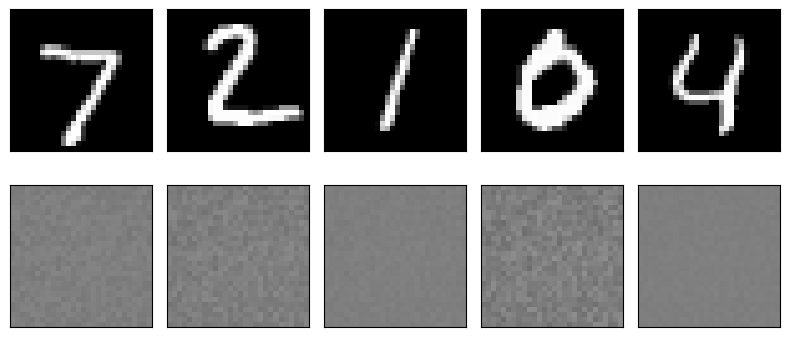

In [18]:
predictions3 = AE3.predict(X_test)
draw_predictions_set(predictions3, 'NB2-MLP-AE3')

In [19]:
# A deeper autoencoder

num_latent_vars = 20

AE4 = Sequential()
AE4.add(Dense(512, input_dim=pixels_per_image, activation='relu'))
AE4.add(Dense(256, activation='relu'))
AE4.add(Dense(num_latent_vars, activation='relu'))
AE4.add(Dense(256, activation='relu'))
AE4.add(Dense(512, activation='relu'))
AE4.add(Dense(pixels_per_image, activation='sigmoid'))
AE4.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "NB2-AE4-weights"
np.random.seed(42)
if not file_helper.load_model_weights(AE4, weights_filename):
    AE4.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(AE4, weights_filename)

Epoch 1/50
469/469 - 6s - 12ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 2/50
469/469 - 4s - 9ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 3/50
469/469 - 4s - 8ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 4/50
469/469 - 4s - 8ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 5/50
469/469 - 4s - 8ms/step - loss: 0.6924 - val_loss: 0.6923
Epoch 6/50
469/469 - 4s - 8ms/step - loss: 0.6922 - val_loss: 0.6921
Epoch 7/50
469/469 - 4s - 8ms/step - loss: 0.6920 - val_loss: 0.6919
Epoch 8/50
469/469 - 4s - 8ms/step - loss: 0.6918 - val_loss: 0.6917
Epoch 9/50
469/469 - 4s - 8ms/step - loss: 0.6916 - val_loss: 0.6915
Epoch 10/50
469/469 - 4s - 8ms/step - loss: 0.6914 - val_loss: 0.6913
Epoch 11/50
469/469 - 4s - 8ms/step - loss: 0.6912 - val_loss: 0.6911
Epoch 12/50
469/469 - 4s - 8ms/step - loss: 0.6910 - val_loss: 0.6909
Epoch 13/50
469/469 - 4s - 8ms/step - loss: 0.6908 - val_loss: 0.6907
Epoch 14/50
469/469 - 4s - 8ms/step - loss: 0.6906 - val_loss: 0.6905
Epoch 15/50
469/469 - 4s - 9

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


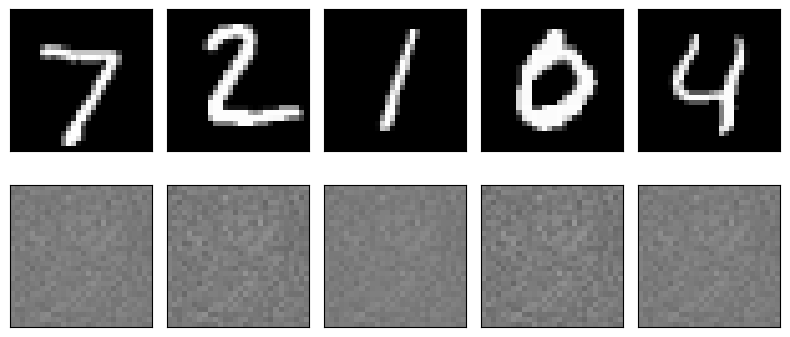

In [20]:
predictions4 = AE4.predict(X_test)
draw_predictions_set(predictions4, 'NB2-MLP-AE4')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


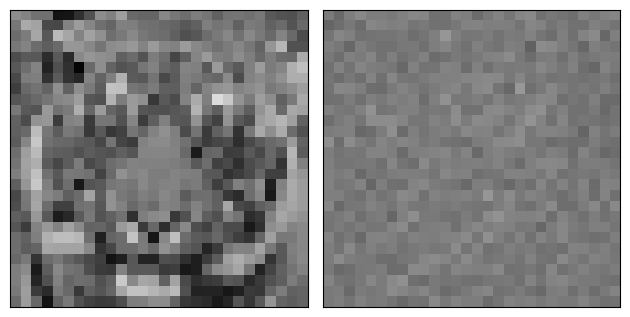

In [21]:
# Tyger, tyger, burning bright...

from PIL import Image

filepath = file_helper.get_input_file_path("tiger-gray-28-28.png")
im = Image.open(filepath) #Can be many different formats.
pix = im.load()
tiger = np.zeros((1,784))
for y in range(28):
    for x in range(28):
        tiger[0,(y*28)+x] = pix[x,y][0]/255.
        
predicted_tiger = AE4.predict(tiger)

plt.subplot(1, 2, 1)
plt.imshow(np.reshape(tiger, (28, 28)), vmin=0, vmax=1, cmap="gray")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.subplot(1, 2, 2)
plt.imshow(np.reshape(predicted_tiger, (28, 28)), vmin=0, vmax=1, cmap="gray")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure('NB2-MLP-AE4-tiger-pair')
plt.show()

In [22]:
##### Second set of figures for the "Exploring" section

In [23]:
# rebuild AE4 with the Functional API so we can play with the decoder alone
from keras.api.layers import Input

num_latent_vars = 20

AE5_encoder_input = Input(shape=(784,))
AE5_encoder_512 = Dense(512, activation='relu')
AE5_encoder_256 = Dense(256, activation='relu')
AE5_encoder_latent = Dense(num_latent_vars, activation='relu')

AE5_decoder_256 = Dense(256, activation='relu')
AE5_decoder_512 = Dense(512, activation='relu')
AE5_decoder_out = Dense(784, activation='sigmoid')

AE5_encoder_step_1 = AE5_encoder_512(AE5_encoder_input)
AE5_encoder_step_2 = AE5_encoder_256(AE5_encoder_step_1)
AE5_encoder_output = AE5_encoder_latent(AE5_encoder_step_2)

AE5_decoder_step_1 = AE5_decoder_256(AE5_encoder_output)
AE5_decoder_step_2 = AE5_decoder_512(AE5_decoder_step_1)
AE5_decoder_output = AE5_decoder_out(AE5_decoder_step_2)

AE5 = Model(AE5_encoder_input, AE5_decoder_output)

AE5_encoder_only_model = Model(AE5_encoder_input, AE5_encoder_output)

AE5_decoder_only_input = Input(shape=(num_latent_vars,))
AE5_decoder_only_step_1 = AE5_decoder_256(AE5_decoder_only_input)
AE5_decoder_only_step_2 = AE5_decoder_512(AE5_decoder_only_step_1)
AE5_decoder_only_output = AE5_decoder_out(AE5_decoder_only_step_2)
AE5_decoder_only_model = Model(AE5_decoder_only_input, AE5_decoder_only_output)

In [24]:
AE5.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "NB2-AE5-weights"
np.random.seed(42)
if not file_helper.load_model_weights(AE5, weights_filename):
    AE5.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(AE5, weights_filename)

Epoch 1/50
469/469 - 5s - 11ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 2/50
469/469 - 4s - 8ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 3/50
469/469 - 4s - 8ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 4/50
469/469 - 4s - 8ms/step - loss: 0.6927 - val_loss: 0.6926
Epoch 5/50
469/469 - 4s - 8ms/step - loss: 0.6925 - val_loss: 0.6924
Epoch 6/50
469/469 - 4s - 8ms/step - loss: 0.6923 - val_loss: 0.6923
Epoch 7/50
469/469 - 4s - 9ms/step - loss: 0.6922 - val_loss: 0.6921
Epoch 8/50
469/469 - 5s - 11ms/step - loss: 0.6920 - val_loss: 0.6919
Epoch 9/50
469/469 - 7s - 14ms/step - loss: 0.6918 - val_loss: 0.6917
Epoch 10/50
469/469 - 4s - 9ms/step - loss: 0.6916 - val_loss: 0.6915
Epoch 11/50
469/469 - 4s - 9ms/step - loss: 0.6914 - val_loss: 0.6913
Epoch 12/50
469/469 - 4s - 9ms/step - loss: 0.6912 - val_loss: 0.6911
Epoch 13/50
469/469 - 4s - 9ms/step - loss: 0.6910 - val_loss: 0.6909
Epoch 14/50
469/469 - 4s - 9ms/step - loss: 0.6908 - val_loss: 0.6907
Epoch 15/50
469/469 - 4s -

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


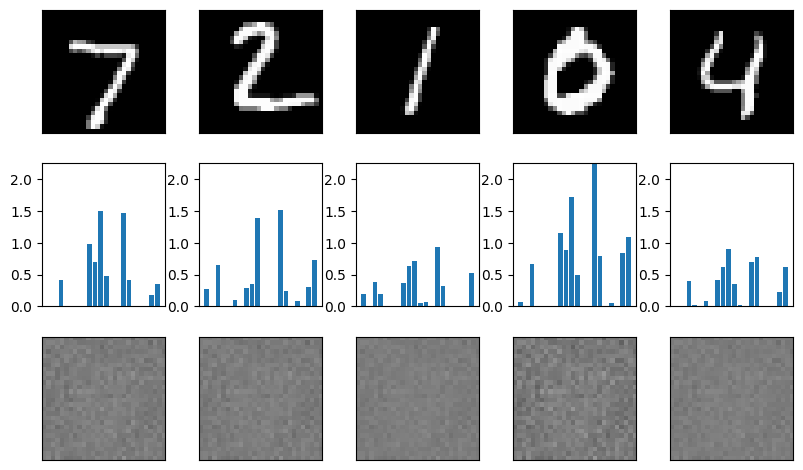

In [25]:
# show the input data, its latent values, and the corresponding predicted images
np.random.seed(random_seed)
encoder_predictions = AE5_encoder_only_model.predict(X_test)

plt.figure(figsize=(8, 5))
latent_min = np.min(encoder_predictions[0:5])
latent_max = np.max(encoder_predictions[0:5])
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+6)
    plt.bar(np.arange(len(encoder_predictions[i])), encoder_predictions[i])
    plt.xticks([], [])
    plt.ylim(latent_min, latent_max)
    
    plt.subplot(3, 5, i+11)
    decoder_model_input = np.resize(encoder_predictions[i], (1, len(encoder_predictions[i])))
    decoder_prediction = AE5_decoder_only_model.predict(decoder_model_input)
    plt.imshow(decoder_prediction.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("NB2-MLP-AE5-latents-and-output")
plt.show()

In [26]:
# show the latent values and the corresponding predicted images
# this makes big vertical spaces between the 
def show_latents_and_predictions(predictions, filename=None):
    plt.figure(figsize=(8, 4))
    latent_min = np.min(predictions[0:5])
    latent_max = np.max(predictions[0:5])
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.bar(np.arange(len(predictions[i])), predictions[i])
        plt.xticks([], [])
        plt.ylim(latent_min, latent_max)

        plt.subplot(2, 5, i+6)
        decoder_model_input = np.resize(predictions[i], (1, len(predictions[i])))
        decoder_prediction = AE5_decoder_only_model.predict(decoder_model_input)
        plt.imshow(decoder_prediction.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


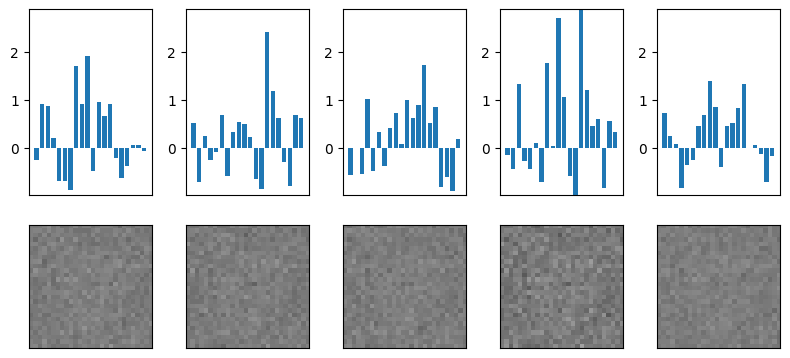

In [27]:
# add [-1,1] noise to all values
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)
noise = 1
for i in range(encoder_predictions.shape[0]):
    for j in range(len(encoder_predictions[i])):
        encoder_predictions[i][j] += np.random.uniform(low=-noise, high=noise)
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-with-noise-1')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


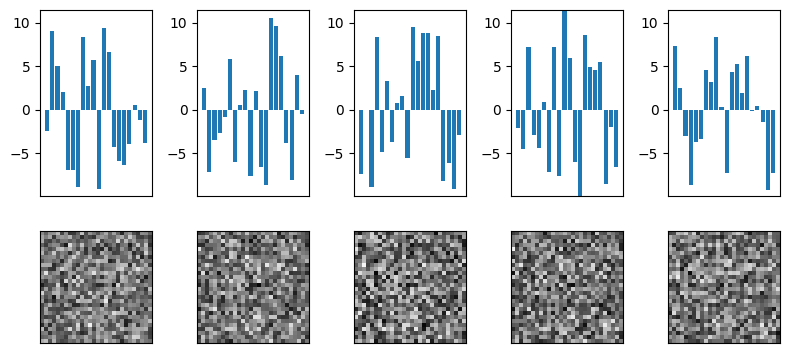

In [28]:
# add [-10,10] noise to all values
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)
noise = 10
for i in range(encoder_predictions.shape[0]):
    for j in range(len(encoder_predictions[i])):
        encoder_predictions[i][j] += np.random.uniform(low=-noise, high=noise)
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-with-noise-10')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


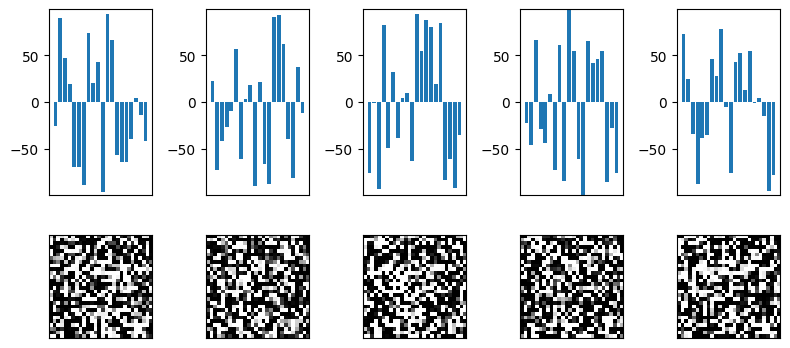

In [29]:
# add [-100,100] noise to all values
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)
noise = 100
for i in range(encoder_predictions.shape[0]):
    for j in range(len(encoder_predictions[i])):
        encoder_predictions[i][j] += np.random.uniform(low=-noise, high=noise)
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-with-noise-100')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


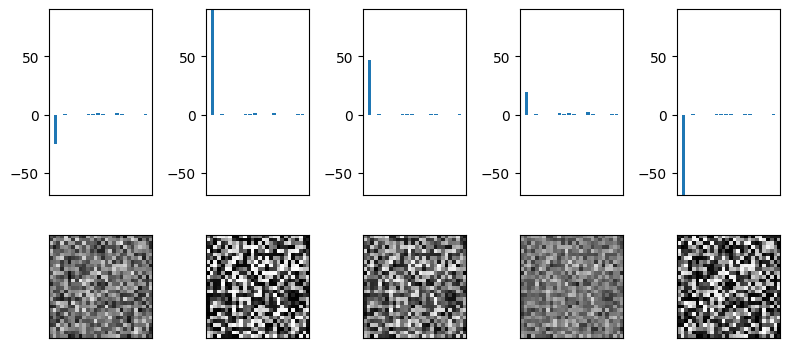

In [30]:
# add [-100,100] noise to just first index
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)
noise = 100
for i in range(encoder_predictions.shape[0]):
    encoder_predictions[i][0] += np.random.uniform(low=-noise, high=noise)
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-with-noise-100-just-index-0')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


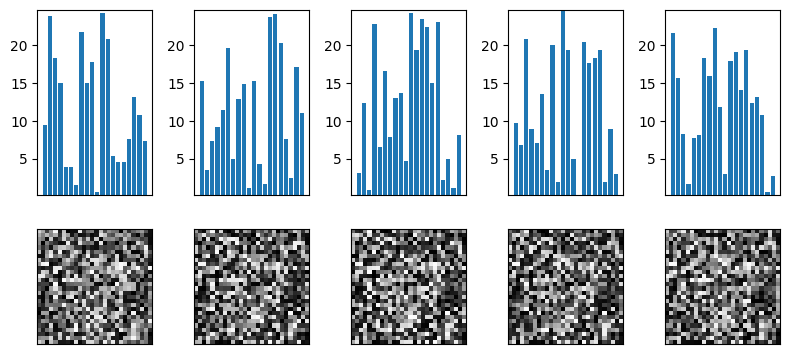

In [31]:
# all latent values are noise
encoder_predictions = np.zeros((5,20))
np.random.seed(random_seed)
noise = 10
for i in range(encoder_predictions.shape[0]):
    encoder_predictions[i] = np.random.uniform(low=0, high=25, size = len(encoder_predictions[i]))
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-just-noise')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


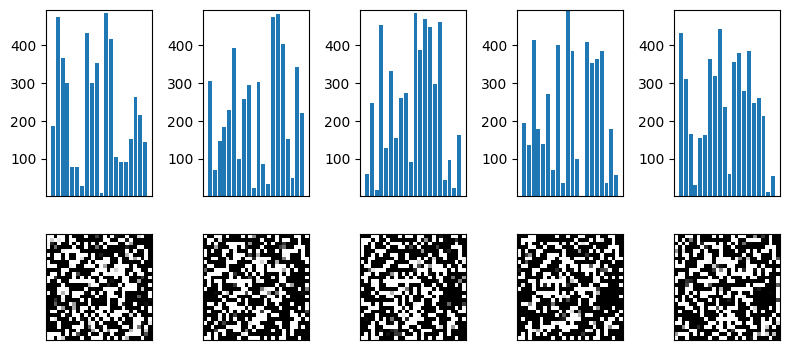

In [32]:
# all latent values are noise
encoder_predictions = np.zeros((5,20))
np.random.seed(random_seed)
noise = 500
for i in range(encoder_predictions.shape[0]):
    encoder_predictions[i] = np.random.uniform(low=0, high=noise, size = len(encoder_predictions[i]))
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-just-noise-500')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


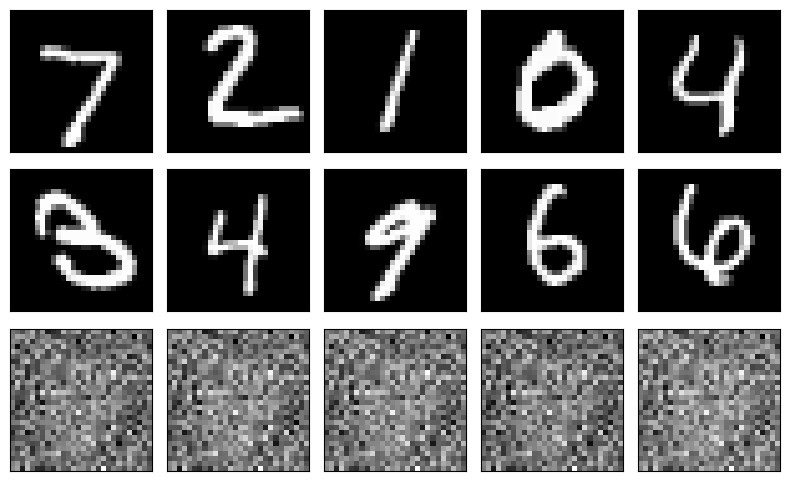

In [33]:
# blend latents for two test images and decompress
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)

plt.figure(figsize=(8, 5))
offset = 18
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+6)
    plt.imshow(X_test[i+offset].reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+11)
    latent0 = encoder_predictions[i]
    latent1 = encoder_predictions[i+offset]
    latent_mix = [(latent0[i]+latent1[i])/2. for i in range(len(latent0))]
    latent_mix = np.reshape(latent_mix, (1,len(latent_mix)))
    decoder_prediction = AE5_decoder_only_model.predict(latent_mix)
    plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("NB2-MLP-AE5-blend-grid")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


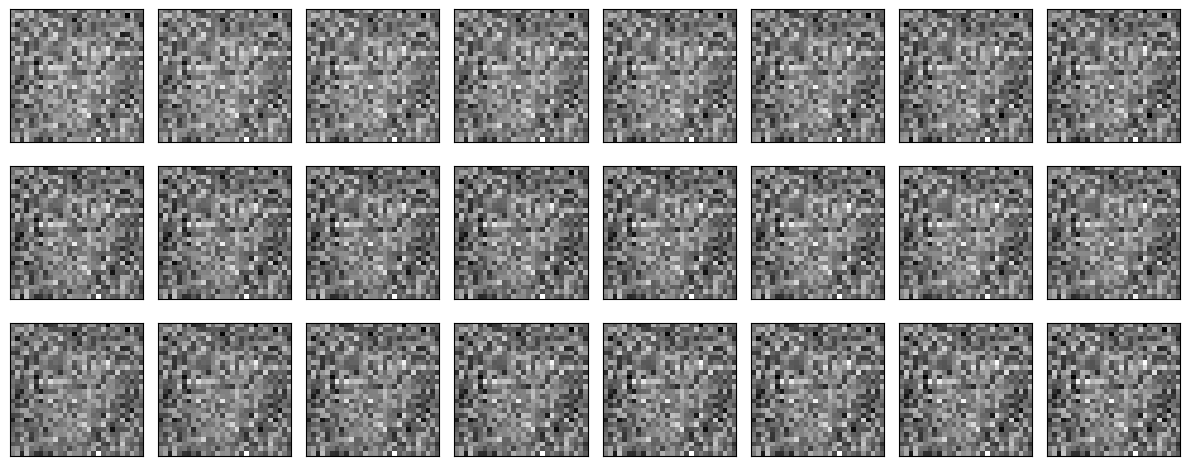

In [34]:
# blend latents for two test images and decompress
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)

steps = 8
plt.figure(figsize=(12, 5))
latent0_list = [ encoder_predictions[4], encoder_predictions[23], encoder_predictions[29]]
latent1_list = [ encoder_predictions[18], encoder_predictions[15], encoder_predictions[25]]

for r in range(3):
    latent0 = latent0_list[r]
    latent1 = latent1_list[r]
    for i in range(steps): 
        plt.subplot(3, steps, (steps*r)+(i+1))
        alpha = i/(steps-1.0)
        latent_mix = [latent0[i]+(alpha*(latent1[i]-latent0[i])) for i in range(len(latent0))]
        latent_mix = np.reshape(latent_mix, (1,len(latent_mix)))
        decoder_prediction = AE5_decoder_only_model.predict(latent_mix)
        plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("NB2-MLP-AE5-blend-linear")
plt.show()

In [35]:
# make a functional model with 2 latent variables for the scatter plot
from keras.api.layers import Input

num_latent_vars = 2

AE6_encoder_input = Input(shape=(784,))
AE6_encoder_512 = Dense(512, activation='relu')
AE6_encoder_256 = Dense(256, activation='relu')
AE6_encoder_latent = Dense(num_latent_vars, activation='relu')

AE6_decoder_256 = Dense(256, activation='relu')
AE6_decoder_512 = Dense(512, activation='relu')
AE6_decoder_out = Dense(784, activation='sigmoid')

AE6_encoder_step_1 = AE6_encoder_512(AE6_encoder_input)
AE6_encoder_step_2 = AE6_encoder_256(AE6_encoder_step_1)
AE6_encoder_output = AE6_encoder_latent(AE6_encoder_step_2)

AE6_decoder_step_1 = AE6_decoder_256(AE6_encoder_output)
AE6_decoder_step_2 = AE6_decoder_512(AE6_decoder_step_1)
AE6_decoder_output = AE6_decoder_out(AE6_decoder_step_2)

AE6 = Model(AE6_encoder_input, AE6_decoder_output)

AE6_encoder_only_model = Model(AE6_encoder_input, AE6_encoder_output)

AE6_decoder_only_input = Input(shape=(num_latent_vars,))
AE6_decoder_only_step_1 = AE6_decoder_256(AE6_decoder_only_input)
AE6_decoder_only_step_2 = AE6_decoder_512(AE6_decoder_only_step_1)
AE6_decoder_only_output = AE6_decoder_out(AE6_decoder_only_step_2)
AE6_decoder_only_model = Model(AE6_decoder_only_input, AE6_decoder_only_output)

AE6.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "NB2-AE6-weights"
np.random.seed(42)
if not file_helper.load_model_weights(AE6, weights_filename):
    AE6.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(AE6, weights_filename)

Epoch 1/50
469/469 - 5s - 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/50
469/469 - 4s - 8ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 3/50
469/469 - 4s - 8ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 4/50
469/469 - 4s - 8ms/step - loss: 0.6927 - val_loss: 0.6926
Epoch 5/50
469/469 - 4s - 8ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 6/50
469/469 - 4s - 8ms/step - loss: 0.6924 - val_loss: 0.6923
Epoch 7/50
469/469 - 4s - 8ms/step - loss: 0.6923 - val_loss: 0.6922
Epoch 8/50
469/469 - 4s - 8ms/step - loss: 0.6921 - val_loss: 0.6920
Epoch 9/50
469/469 - 4s - 8ms/step - loss: 0.6920 - val_loss: 0.6919
Epoch 10/50
469/469 - 4s - 8ms/step - loss: 0.6918 - val_loss: 0.6918
Epoch 11/50
469/469 - 4s - 8ms/step - loss: 0.6917 - val_loss: 0.6916
Epoch 12/50
469/469 - 4s - 8ms/step - loss: 0.6916 - val_loss: 0.6915
Epoch 13/50
469/469 - 4s - 8ms/step - loss: 0.6914 - val_loss: 0.6913
Epoch 14/50
469/469 - 4s - 8ms/step - loss: 0.6913 - val_loss: 0.6912
Epoch 15/50
469/469 - 4s - 9

In [36]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
  
# scatter plot from AE6
def draw_scatter(diameter, limits=None, filename=None):
    encoder_predictions = np.array(AE6_encoder_only_model.predict(X_test))
    np.random.seed(random_seed)

    plt.clf()
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(111, aspect='equal')

    # display a 2D plot of the digit classes in the latent space
    clrs = [ 'red', 'sandybrown', 'sienna', 'gold', 'palegreen',
            'limegreen', 'deepskyblue', 'blue', 'plum', 'magenta' ]

    for i in range(len(encoder_predictions)):
        p = patches.Circle(encoder_predictions[i], diameter,
                            edgecolor='black', facecolor=clrs[y_test[i]])
        ax.add_patch(p)

    handle_list = []
    for i in range(10):
        p = patches.Patch(color=clrs[i], label=str(i))
        handle_list.append(p)
    ax.legend(handles=handle_list, loc='upper right', shadow=True)

    if limits:
        (pxmin, pxmax, pymin, pymax) = limits
    else:
        xmin = np.min(encoder_predictions[:,0])
        xmax = np.max(encoder_predictions[:,0])
        pxmin = xmin - (.05 * (xmax-xmin))
        pxmax = xmax + (.15 * (xmax-xmin))
        ymin = np.min(encoder_predictions[:,1])
        ymax = np.max(encoder_predictions[:,1])
        pymin = ymin - (.05 * (ymax-ymin))
        pymax = ymax + (.05 * (ymax-ymin))
    ax.set_ylim([pymin, pymax])
    ax.set_xlim([pxmin, pxmax])

    file_helper.save_figure(filename)

    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


C:\Users\office27\AppData\Local\Temp\ipykernel_3712\1141133258.py:41: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([pxmin, pxmax])


<Figure size 640x480 with 0 Axes>

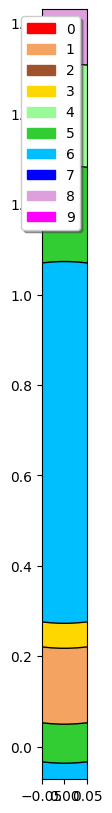

In [37]:
draw_scatter(.4, limits=None, filename='NB2-MLP-AE6-latent-scatter')

In [38]:
def draw_decoder_grid(steps=17, limits=None, filename=None):

    # display a 2D manifold of the digits
    digit_size = 28
    figure = np.zeros((digit_size * steps, digit_size * steps))
    grid_x = np.linspace(limits[1], limits[0], steps)
    grid_y = np.linspace(limits[2], limits[3], steps) 

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            
            latents = np.array([[xi, yi]])
            decoder_prediction = AE6_decoder_only_model.predict(latents)
            
            digit = decoder_prediction[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(figure, cmap='gray')
    file_helper.save_figure(filename)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

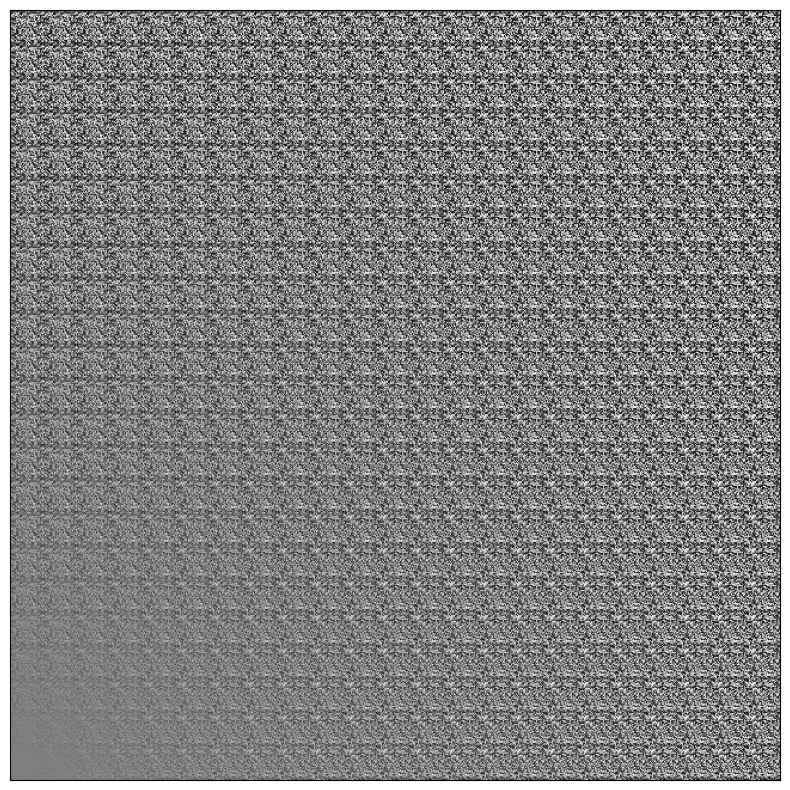

In [39]:
draw_decoder_grid(steps=23, limits=(0, 55, 0, 55), filename='NB2-MLP-AE6-17-decoder-grid')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


<Figure size 640x480 with 0 Axes>

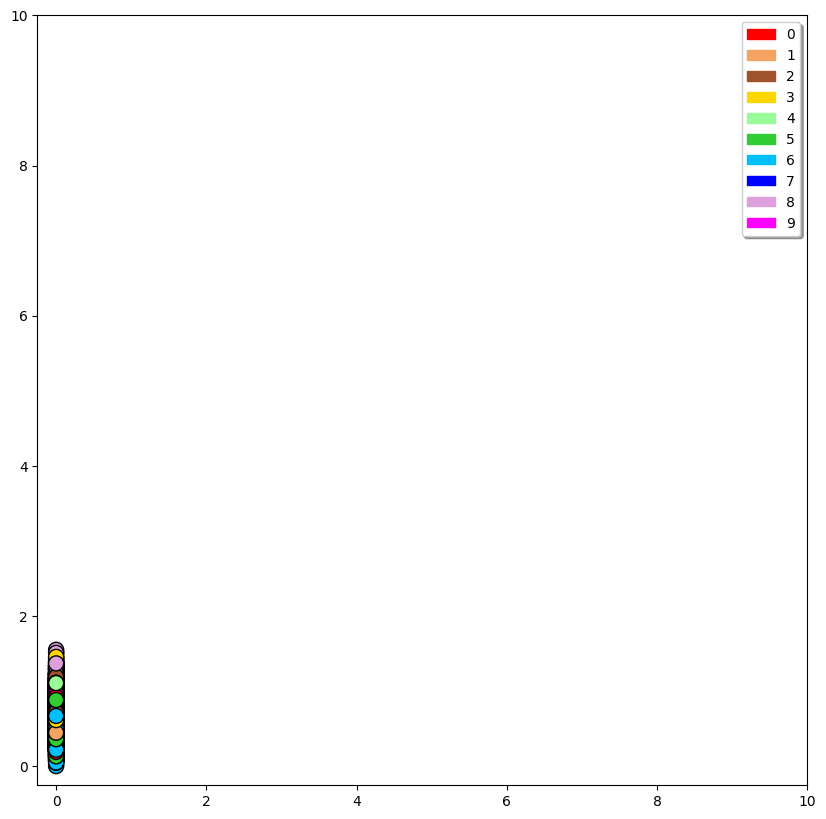

In [40]:
draw_scatter(.1, limits=(-.25, 10, -.25, 10), filename='NB2-MLP-AE6-latent-scatter-cu')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

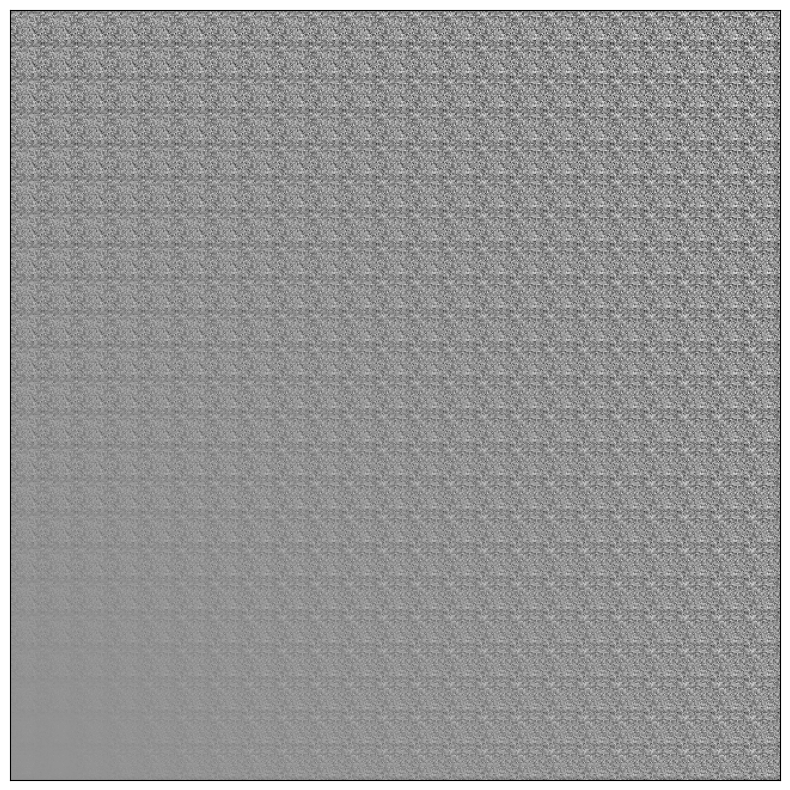

In [41]:
draw_decoder_grid(steps=23, limits=(-.25, 10, -.25, 10), filename='NB2-MLP-AE6-17-decoder-grid-CU')

In [42]:
def show_from_latents(latents_list, filename=None):
    numplots = len(latents_list)
    plt.clf()
    plt.figure(figsize=(4*numplots, 4))
    for i in range(numplots):
        latents = np.array(latents_list[i])
        latent_grid = np.resize(latents, (1,len(latents)))
        decoder_prediction = AE6_decoder_only_model.predict(latent_grid)
        plt.subplot(1, numplots, i+1)
        plt.imshow(np.reshape(decoder_prediction, (28,28)), cmap='gray')
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<Figure size 640x480 with 0 Axes>

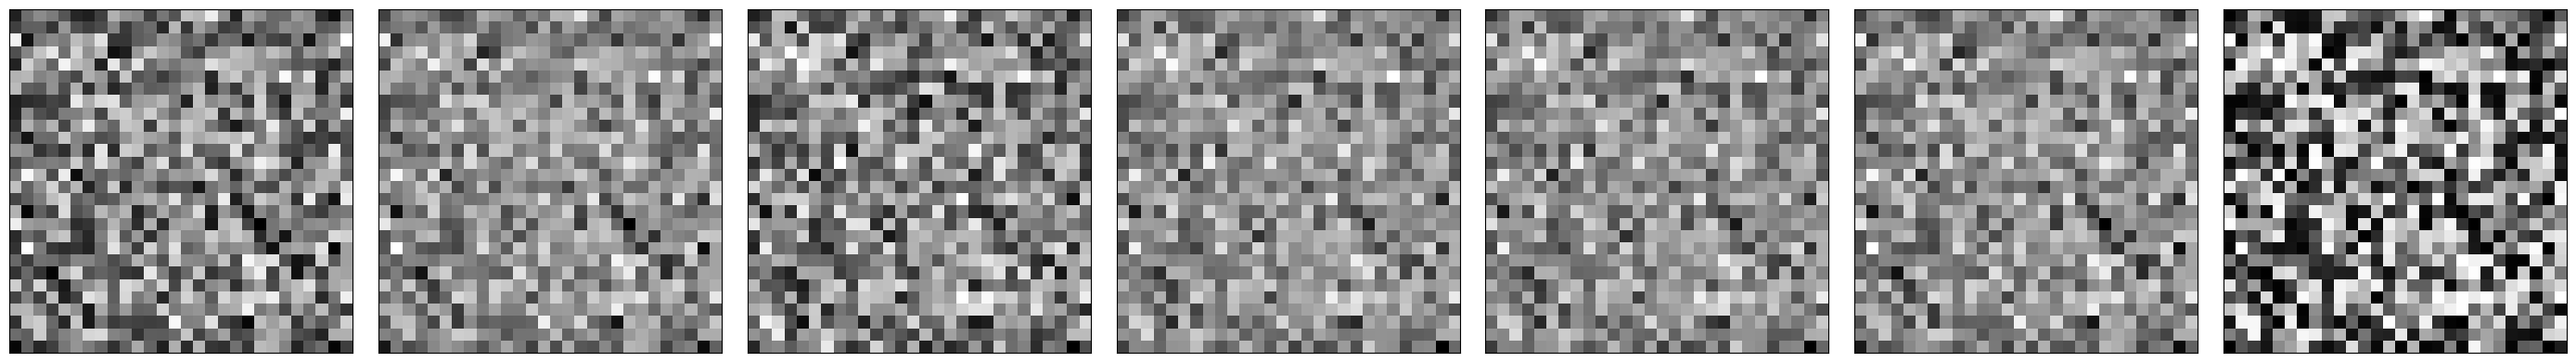

In [43]:
show_from_latents(
    ((2,30),(.5,5),(23,17),(3,4),(5,7),(1,8),(30,60)),
    #((2,0),(5,2),(4,6),(8,11),(35,55),(33.5,25), (40,13)), 
    'NB2-MLP-AE6-whitespace-predictions')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━

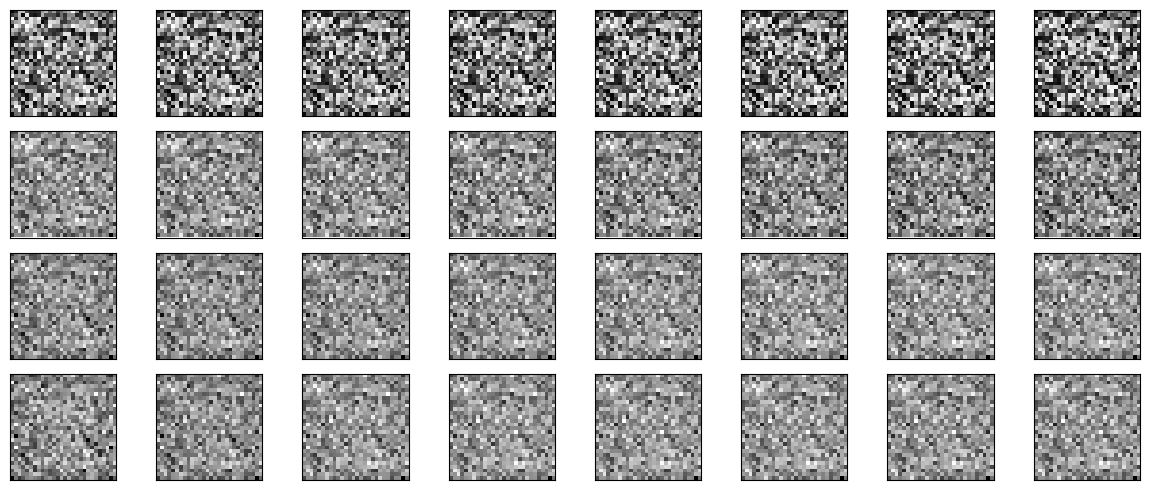

In [44]:
# blend latents for two test images and decompress
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)

steps = 8
plt.figure(figsize=(12, 5))
#latent0_list = [ (5,25), (6,.5), (3,3), (3,3)]
#latent1_list = [ (25, 60) , (30,5), (2,6), (30,35)]
latent0_list = [(30,35), (15,5), (1,3), (0,2)]
latent1_list = [(10,55), (10,20), (6,5), (9,5)]

for r in range(len(latent0_list)):
    latent0 = latent0_list[r]
    latent1 = latent1_list[r]
    for i in range(steps): 
        plt.subplot(len(latent0_list), steps, (steps*r)+(i+1))
        alpha = i/(steps-1.0)
        latent_mix = [latent0[i]+(alpha*(latent1[i]-latent0[i])) for i in range(len(latent0))]
        latent_mix = np.reshape(latent_mix, (1,len(latent_mix)))
        decoder_prediction = AE6_decoder_only_model.predict(latent_mix)
        plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure('NB2-MLP-AE6-blend-linear-through-scatter')
plt.show()